# Classical-quantum trajectories

In this notebook we generate the example classical-quantum trajectories appearing in the Appendix of [https://arxiv.org/abs/2208.11722](https://arxiv.org/abs/2208.11722).

### Basics of the code

Let's start by importing the usual dependencies:

In [1]:
import numpy as np
import matplotlib.pyplot as plt

The core goal in what follows is to simulate how a classical and quantum system interact. Their evolution may be represented entirely by the classical point in phase space $Z_s$ and the quantum state $\rho_s$ (or $|\psi\rangle_s$ for pure states) at each point in time $s$, and so these will intially appear in the code as

In [2]:
N=10**6 #number of timesteps in simulation

Z_s=np.zeros(N + 1)
rho_s = np.zeros((N + 1,2,2),dtype = 'complex_')
psi_s = np.zeros((N + 1,2),dtype = 'complex_')

The remaining task is to fill in these blank vectors by a suitable numerical approximation to the dynamics. The dynamics generating these trajectories are generally stochastic differential equations of the form

$$ dZ_t=\mu(\rho,Z) dt + \sigma(Z) dW $$
$$ d\rho_t=f(\rho,Z) dt + g(\rho,Z) dW $$

As the applications of the current work are to illustrate how classical-quantum trajectories appear in toy models and provide proof-of-principle for their simulation, we will only consider the most basic of stochastic finite difference schemes, known as the [Euler-Maruyama method](https://en.wikipedia.org/wiki/Euler%E2%80%93Maruyama_method). The idea here is to generate the Wiener increment via

In [3]:
state=np.random.RandomState(seed=1) #fix a seed

def dW(delta_t):
    return state.normal(loc=0.0, scale=np.sqrt(delta_t))

and then simulate the stochastic differential equation by considering the above stochastic differential equations as defining the increment to add to $Z_t$ or $\rho_t$ at each timestep to find $Z_{t+\delta t}$,$\rho_{t+\delta t}$. Having done this, we may plot the relevant trajectory in phase space and Hilbert space using a suitable representation such as the Bloch sphere. Since it is not necessary for high numerical accuracy to understand the qualitative behaviour of these toy systems, we will assume that provided the trace of the quantum system is close to 1 the numerical model is behaving suitably well – in most cases this can be simply verified by looking at the path of the trajectory when plotted in (a Bloch sphere representation of) Hilbert space.

## Qubit and 1D particle


First, we define some operators/functions that we shall need for simulating and plotting a qubit/classical 1D particle's coupled trajectories:

In [4]:
sx=np.array([[0,1],[1,0]])
sy=np.array([[0,-1j],[1j,0]])
sz=np.array([[1,0],[0,-1]]) 
I =np.identity(2)
plus_state=np.array([[1/2,1/2],[1/2,1/2]],dtype = 'complex_')
plus_vector=np.array([1/np.sqrt(2),1/np.sqrt(2)])

def Exp(A,v):
    return np.vdot(v,np.dot(A,v))

def opVsExp(A,v):
    return A-np.identity(2)*np.vdot(v,np.dot(A,v))

#increase default resolution
plt.rcParams["figure.dpi"] = 300

def plot_quant(ax,state_s, #axis to draw on and input quantum traj
               color="orange",ls="solid",lw=0.4, #style defaults
               plotSphere=True,zorder=5, #for plotting multiple trajectories on a single axis
               northpole_is_0=True): #choose state on top of Bloch sphere
    
    if northpole_is_0:
        pole_op=sz
    else:
        pole_op=-sz
    
    if np.shape(state_s[0])==(2,): #for plotting hilbert vector trajectories
        xs=[np.real(Exp(sx,psi)) for psi in state_s]
        ys=[np.real(Exp(sy,psi)) for psi in state_s]
        zs=[np.real(Exp(pole_op,psi)) for psi in state_s]
    
    elif np.shape(state_s[0])==(2,2): #for density operator trajectories
        xs=[np.real(np.trace(rho.dot(sx))) for rho in state_s]
        ys=[np.real(np.trace(rho.dot(sy))) for rho in state_s]
        zs=[np.real(np.trace(rho.dot(pole_op))) for rho in state_s]
        
    else:
        print("The inputted state does not appear to be of a qubit.")
    
    
    
    if plotSphere:
        r = 1
        pi = np.pi
        cos = np.cos
        sin = np.sin
        phi, theta = np.mgrid[0.0:pi:100j, 0.0:2.0*pi:100j]
        x = r*sin(phi)*cos(theta)
        y = r*sin(phi)*sin(theta)
        z = r*cos(phi)

        ax.plot_wireframe(x, y, z, rstride=5, cstride=5, color='g', alpha=0.5, linewidth=0.2,zorder=0)
    
    
        ax.plot([0,1],[0,0],[0,0],'k-', linewidth=1,linestyle="dashed",alpha=0.5)
        ax.plot([0,0],[0,1],[0,0],'k-', linewidth=1,linestyle="dashed",alpha=0.5)
        ax.plot([0,0],[0,0],[0,1],'k-', linewidth=1,linestyle="dashed",alpha=0.5)
    
    ax.plot(xs, ys, zs,linewidth=lw,alpha=1,color=color,zorder=zorder,linestyle=ls)

    if plotSphere:
        ax.plot([1,1.2],[0,0],[0,0],'k-', linewidth=1,zorder=10)
        ax.plot([0,0],[1,1.2],[0,0],'k-', linewidth=1,zorder=10)
        ax.plot([0,0],[0,0],[1,1.2],'k-', linewidth=1,zorder=10)

        ax.set_facecolor("none")
        ax.set_axis_off()
        ax.set_xlim(-1, 1)
        ax.set_ylim(-1, 1)
        ax.set_zlim(-1, 1)
    
def plot_class(ax,Q_s,P_s,
               color="orange",ls="solid",lw="0.3",grid=False,
               zorder=5):
    ax.plot(Q_s,P_s,linewidth=lw,color=color,linestyle=ls,zorder=zorder)
    ax.set_xlabel("Q")
    ax.set_ylabel("P")
    ax.grid(grid)
    

### Linear coupling

We first wish to solve numerically the Hamiltonian

$$H=2\lambda q \hat{\sigma}_z + \phi \hat{\sigma}_z + \frac{p^2}{2m}$$

for the case of constant noise in $p$.

For convenience later on, we will define a function that simulates the dynamics of Appendix C1 (note here we use the density operator representation, rather than the Hilbert vector representation):

In [5]:
def linearDynamics(q_i=0,p_i=0,rho_i=plus_state, #default initial conditions
                   t_i=0,t_f=1,N=100000, #default duration and stepsize
                   m=1,sigma=1,lambd=1,phi=2, #default free parameters
                   v=0, standard_semi_class=False): #by default decoherence-diffusion trade-off is saturated
    
    #time step
    dt     = float(t_f - t_i) / N

    #state space set-up
    ts = np.linspace(t_i, t_f, N)
    P_s = np.zeros(N)
    Q_s = np.zeros(N)
    rho_s = np.zeros((N,2,2),dtype = 'complex_')

    #intial conditions
    Q_s[0]=q_i
    P_s[0]=p_i
    rho_s[0]=rho_i
    
    #fix decoherence in terms of the size of the violation v
    D0 = (1+abs(v))*((lambd*lambd)/(sigma*sigma))
    
    #turn off certain terms for standard semi-classical prediction
    a=1
    if standard_semi_class:
        a=0
    
    #euler-maruyama numerics
    for i in range(1, N):
        t = t_i + (i - 1) * dt
        P = P_s[i - 1]
        Q = Q_s[i - 1]
        rho = rho_s[i - 1]
        dw=dW(dt)
        P_s[i] = P + (2*np.real(np.trace(rho.dot(sz)))*lambd)*dt + a* sigma * dw
        Q_s[i] = Q + (P/m)*dt
        rho_s[i] = rho - 1j*(Q*2*lambd+phi)*( sz.dot(rho)-rho.dot(sz))*dt \
        + a*D0*(sz.dot(rho.dot(sz))-(1/2)*(sz.dot(sz.dot(rho))+rho.dot(sz.dot(sz))))*dt \
        + a*(lambd/sigma)*(sz.dot(rho)+rho.dot(sz)-2*np.trace(sz.dot(rho))*rho)*dw
        
    return (rho_s,Q_s,P_s)

We now run the dynamics for a given realisation and plot the results:

In [6]:
#fix a seed 
state=np.random.RandomState(seed=1)

#numerically solve dynamics with default parameters
(rho_s,Q_s,P_s)=linearDynamics()

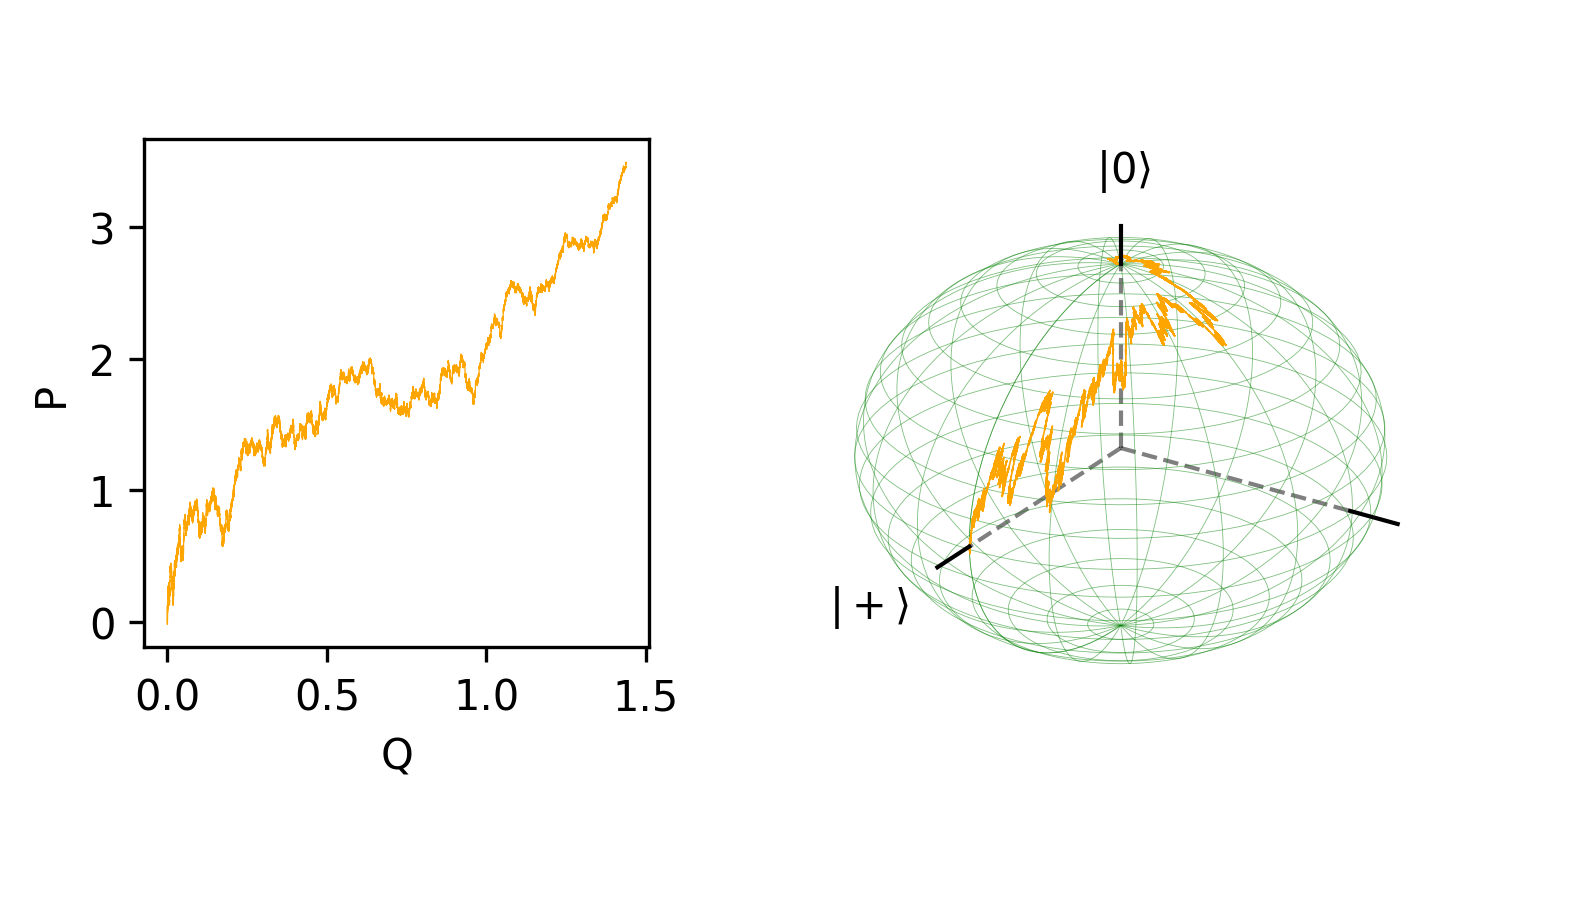

In [7]:
#define figure allowing multiple subplots
fig = plt.figure(facecolor="white")
spec = fig.add_gridspec(7, 8)
fig.tight_layout()

#classical trajectory subplot
ax = fig.add_subplot(spec[1:5,0:3])
plot_class(ax,Q_s,P_s)

#ax.set_xlim(-0.1, 1.5)
#ax.set_ylim(-0.1, 3.7)

#quantum trajectory subplot
ax2= fig.add_subplot(spec[0:7,3:8],projection='3d')
plot_quant(ax2,rho_s)
ax2.text(1.85,0,0.1,r'$|+\rangle$')
ax2.text(0,-0.11,1.4,r'$|0\rangle$')
ax2.view_init(elev=25., azim=33)

plt.show()

A parameter of the above function controls the use of the standard semi-classical result for the same Hamiltonian (note that we could also achieve this by simply commenting out the terms with $\sigma$/$D_0$ dependence!). We can thus compare the dynamics of the two theories, and also see how there are two fixed points for the quantum state:

In [8]:
#solve for one noise realisation
state=np.random.RandomState(seed=1)
(rho_s_1,Q_s_1,P_s_1)=linearDynamics(p_i=10,t_f=0.45,N=45000,sigma=0.8)

#solve the dynamics for another realisation
state=np.random.RandomState(seed=60)
(rho_s_2,Q_s_2,P_s_2)=linearDynamics(p_i=10,t_f=0.45,N=45000,sigma=0.8)

#solve the standard semi-classical equations
(rho_s_stand,Q_s_stand,P_s_stand)=linearDynamics(p_i=10,t_f=0.45,N=45000,standard_semi_class=True)

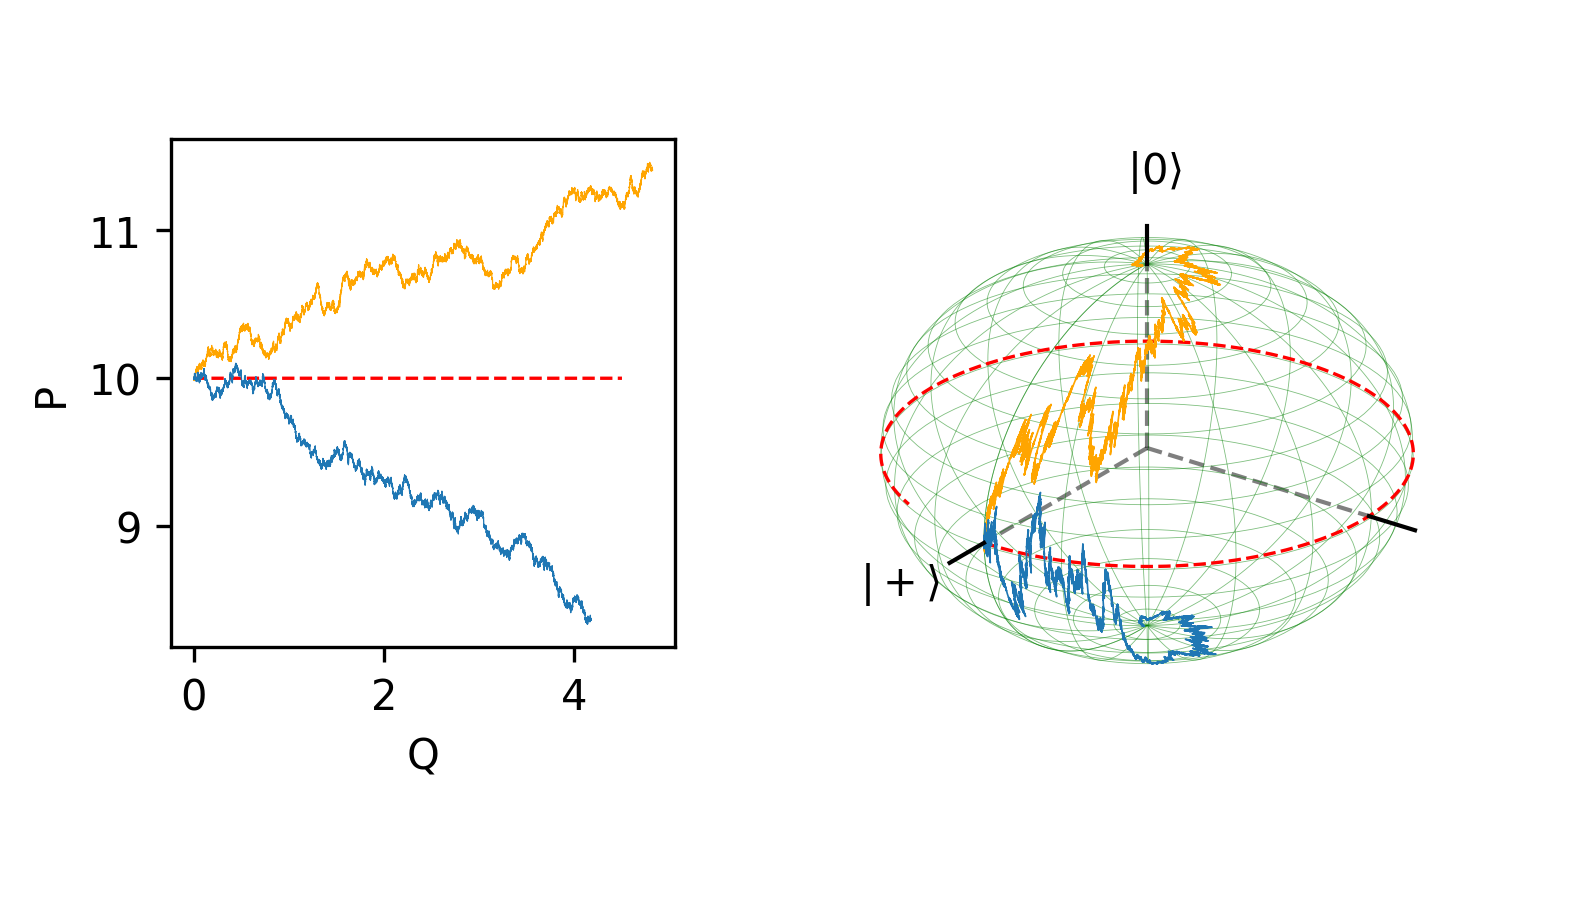

In [9]:
#define figure allowing multiple subplots
fig = plt.figure(facecolor="white")
spec = fig.add_gridspec(7, 8)
fig.tight_layout()

#classical trajectories subplot
ax = fig.add_subplot(spec[1:5,0:3])

plot_class(ax,Q_s_1,P_s_1,color="orange")
plot_class(ax,Q_s_2,P_s_2,color="C0")
plot_class(ax,Q_s_stand,P_s_stand,color="red",ls="dashed",lw=0.8,zorder=3)

#quantum trajectories subplot
ax2= fig.add_subplot(spec[0:7,3:8],projection='3d')

plot_quant(ax2,rho_s_1,color="orange")
plot_quant(ax2,rho_s_2,color="C0",plotSphere=False)
plot_quant(ax2,rho_s_stand,color="red",ls="dashed",lw=0.8,plotSphere=False,zorder=4)

ax2.text(1.7,0,0.1,r'$|+\rangle$')
ax2.text(0,-0.09,1.4,r'$|0\rangle$')
ax2.view_init(elev=25., azim=36)

plt.show()

One may also investigate the effects of varying $\sigma$:

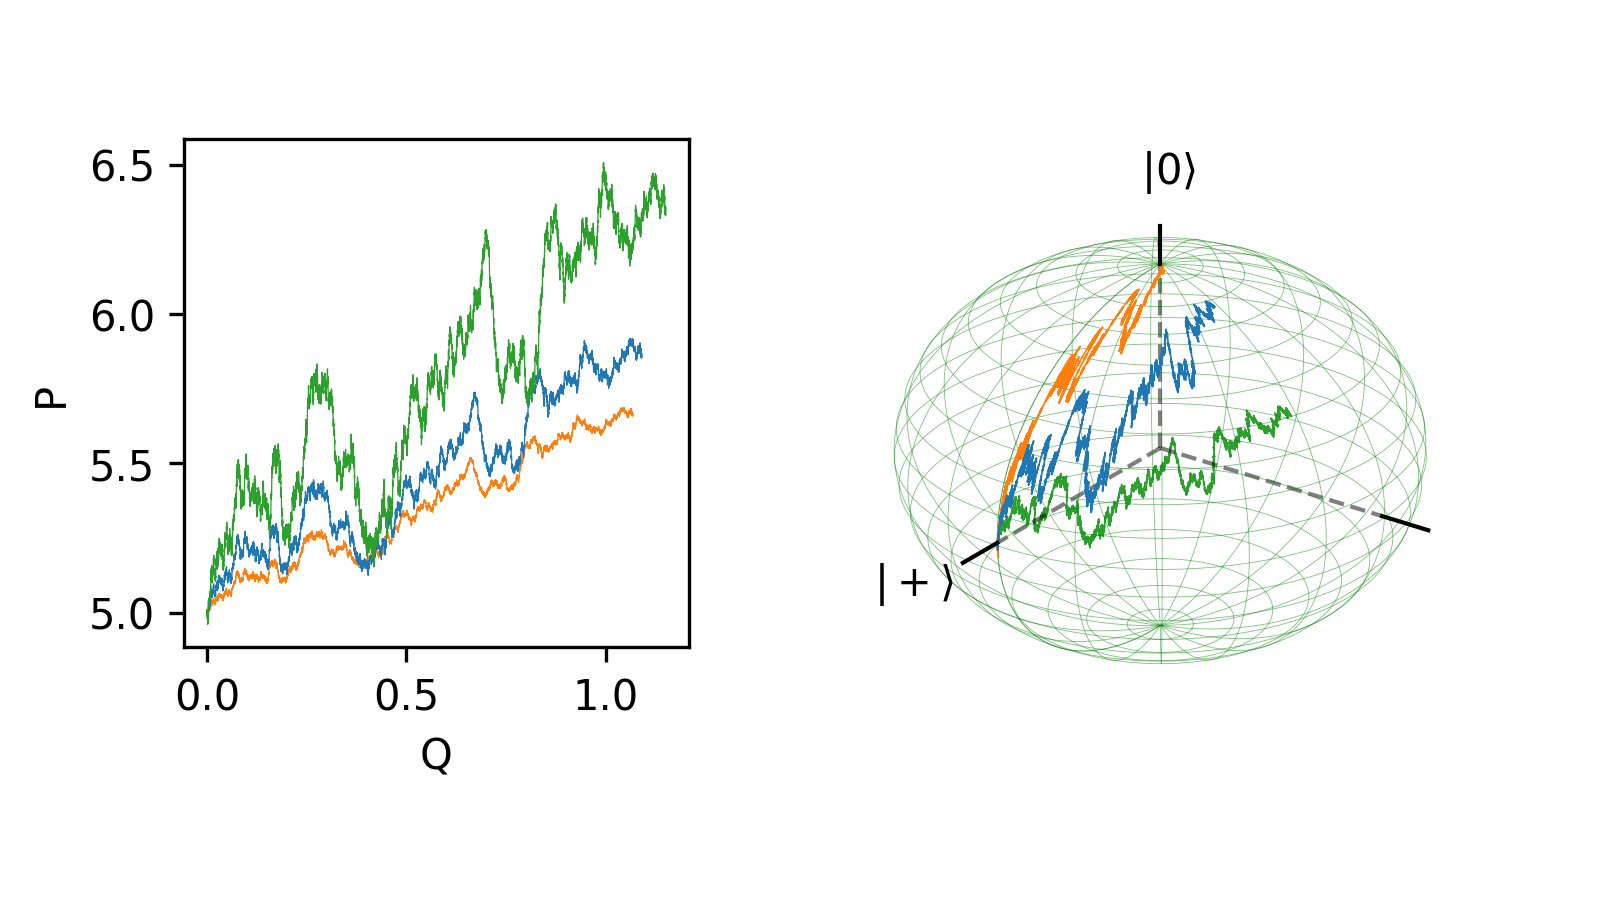

In [10]:
#solve for same noise realisation for multiple sigma
state=np.random.RandomState(seed=1)
(rho_s_1,Q_s_1,P_s_1)=linearDynamics(p_i=5,t_f=0.2,N=20000,sigma=0.5)
state=np.random.RandomState(seed=1)
(rho_s_2,Q_s_2,P_s_2)=linearDynamics(p_i=5,t_f=0.2,N=20000,sigma=1)
state=np.random.RandomState(seed=1)
(rho_s_3,Q_s_3,P_s_3)=linearDynamics(p_i=5,t_f=0.2,N=20000,sigma=2)

#define figure allowing multiple subplots
fig = plt.figure(facecolor="white")
spec = fig.add_gridspec(7, 8)
fig.tight_layout()

#classical trajectories subplot
ax = fig.add_subplot(spec[1:5,0:3])

plot_class(ax,Q_s_1,P_s_1,color="C1")
plot_class(ax,Q_s_2,P_s_2,color="C0")
plot_class(ax,Q_s_3,P_s_3,color="C2")

#quantum trajectories subplot
ax2= fig.add_subplot(spec[0:7,3:8],projection='3d')

plot_quant(ax2,rho_s_1,color="C1")
plot_quant(ax2,rho_s_2,color="C0",plotSphere=False)
plot_quant(ax2,rho_s_3,color="C2",plotSphere=False,zorder=0)

ax2.text(1.7,0,0.1,r'$|+\rangle$')
ax2.text(0,-0.09,1.4,r'$|0\rangle$')
ax2.view_init(elev=25., azim=36)

plt.show()

i.e. the more diffusion on the classical trajectory, the slower the quantum state evolves to one of the $\hat{\sigma}_z$ eigenstates.

### $\sqrt{q}$ potential

Consider now the following Hamiltonian from Appendix C2

$$\hat{H}(q,p)=\lambda \sqrt{q} \hat{\sigma}_z + \frac{p^2}{2m}$$

with a non-constant diffusion term

$$ \sigma(q)=\gamma q^{-\frac{1}{2}}.$$

This gives the folowing evolution dynamics (note we will only consider q>0):

In [11]:
def sqrtDynamics(q_i=1,p_i=-1,psi_i=plus_vector, #default initial conditions
                   t_i=0,t_f=2,N=200000, #default duration and stepsize
                   m=1,sigma=1,lambd=1,gamma=0.5): #default free parameters
    
    #time step
    dt     = float(t_f - t_i) / N

    #state space set-up
    ts = np.linspace(t_i, t_f, N)
    Q_s = np.zeros(N)
    P_s = np.zeros(N)
    psi_s = np.zeros((N,2),dtype = 'complex_')

    #intial conditions
    Q_s[0]=q_i
    P_s[0]=p_i
    psi_s[0]=psi_i
    
    #euler-maruyama numerics
    for i in range(1, N):
        t = t_i + (i - 1) * dt
        P = P_s[i - 1]
        Q = Q_s[i - 1]
        psi = psi_s[i - 1]
        dw=dW(dt)
        P_s[i] = P - lambd* (1/(2*np.sqrt(np.abs(Q))))* np.real(Exp(sz,psi))*dt + (gamma/np.sqrt(np.abs(Q))) * dw
        Q_s[i] = Q +(P/m)*dt
        psi_s[i] = psi - 1j*lambd*np.sqrt(np.abs(Q))*sz.dot(psi)*dt \
        - (lambd/(4*gamma))* opVsExp(sz,psi).dot(psi)* dw \
        - (lambd*lambd/(32*gamma*gamma)) * (opVsExp(sz,psi)*opVsExp(sz,psi)).dot(psi)* dt
        
        if Q<0: #stop updating when Q<0
            Q_s[i] = Q
            P_s[i] = P
            psi_s[i] = psi
        
    return (psi_s,Q_s,P_s,ts)

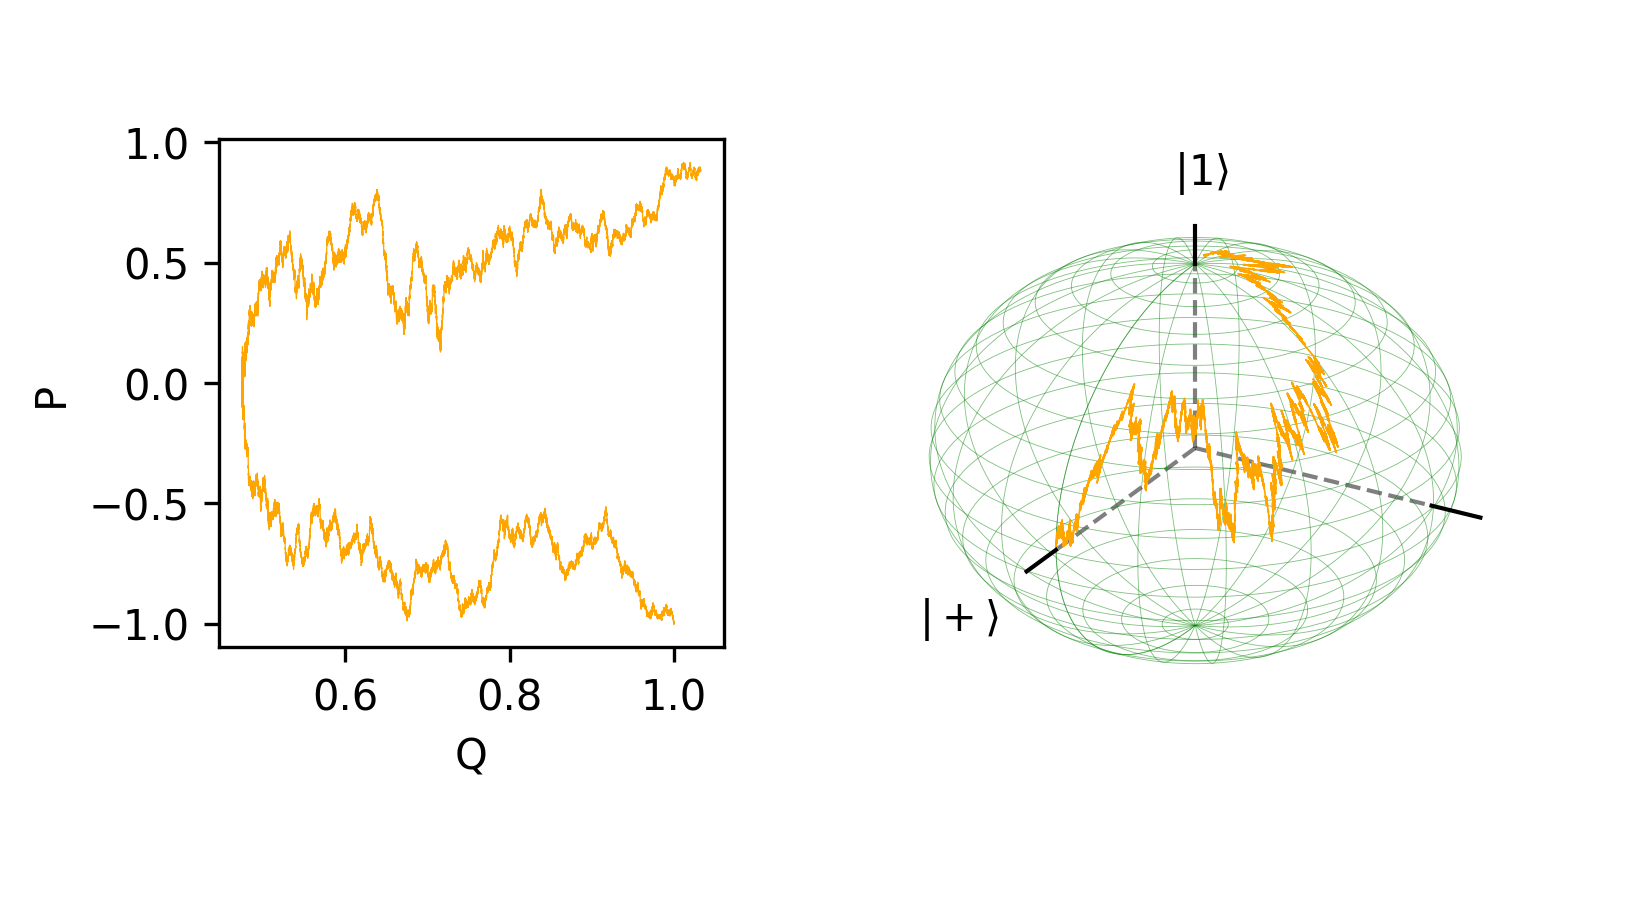

In [12]:
#fix a seed 
state=np.random.RandomState(seed=66) 

#numerically solve dynamics with default parameters
(rho_s,Q_s,P_s,ts)=sqrtDynamics()

#define figure allowing multiple subplots
fig = plt.figure(facecolor="white")
spec = fig.add_gridspec(7, 8)
fig.tight_layout()

#classical trajectory subplot
ax = fig.add_subplot(spec[1:5,0:3])
plot_class(ax,Q_s,P_s)
#ax.set_xlim(-0.1, 1.5)
#ax.set_ylim(-0.1, 3.7)

#quantum trajectory subplot
ax2= fig.add_subplot(spec[0:7,3:8],projection='3d')
plot_quant(ax2,rho_s,northpole_is_0=False)
ax2.text(1.9,0,0.1,r'$|+\rangle$')
ax2.text(0,-0.09,1.4,r'$|1\rangle$')
ax2.view_init(elev=25., azim=30)

plt.show()

This corresponds to a particle bouncing off a potential barrier, rather than falling down a potential well.

## Toy model of mass in superposition

We now wish to describe a classical system in 3D. Specifically, we wish to describe the trajectories of a classical test mass as it moves in the potential generated by a mass in superposition. As described in Appendix C3, a toy model for this is described by

$$\hat{H}(\textbf{r},\textbf{p})=\frac{\textbf{p}\cdot\textbf{p}}{2m}-\frac{GMm}{|\textbf{r}-\hat{\sigma}_z\textbf{d}|} + \phi \hat{\sigma}_z, \quad\quad \hat{\sigma}_z=|L\rangle\langle L|-|R\rangle\langle R| $$

where the noise is taken to be constant in $p_x,p_y,p_z$. 

In [13]:
def Hx(x,y,z,G,M,m,e,d):
    return np.array([[(-1*G*M*m*(x+d)/(np.sqrt((x+d)**2+y**2+z**2+e**2)**3)),0],\
                     [0,(-1*G*M*m*(x-d)/(np.sqrt((x-d)**2+y**2+z**2+e**2)**3))]])
def Hy(x,y,z,G,M,m,e,d):
    return np.array([[(-1*G*M*m*(y)/(np.sqrt((x+d)**2+y**2+z**2+e**2)**3)),0],\
                     [0,(-1*G*M*m*(y)/(np.sqrt((x-d)**2+y**2+z**2+e**2)**3))]])
def Hz(x,y,z,G,M,m,e,d):
    return np.array([[(-1*G*M*m*(z)/(np.sqrt((x+d)**2+y**2+z**2+e**2)**3)),0],\
                     [0,(-1*G*M*m*(z)/(np.sqrt((x-d)**2+y**2+z**2+e**2)**3))]])
def H(x,y,z,G,M,m,e,d):
    return np.array([[(-1*G*M*m/(np.sqrt((x+d)**2+y**2+z**2+e**2))),0],\
                     [0,(-1*G*M*m/(np.sqrt((x-d)**2+y**2+z**2+e**2)))]])

def normCheck(psi,t,tolerance):
    norm=Exp(I,psi)
    if norm>1+tolerance or norm<1-tolerance:    
        print("Norm is {0} at time {1}".format(norm,t))
        return 1  
              
    else:
        return 0
    
def zComponentPlot(ax,state_s,ts,
                   color="orange",lw=0.3,
                   northpole_is_0=True):
    
    if northpole_is_0:
        pole_op=sz
    else:
        pole_op=-sz
    
    if np.shape(state_s[0])==(2,): #for plotting hilbert vector trajectories
        zs=[np.real(Exp(pole_op,psi)) for psi in state_s]
    
    elif np.shape(state_s[0])==(2,2): #for density operator trajectories
        zs=[np.real(np.trace(rho.dot(pole_op))) for rho in state_s]
        
    ax.plot(ts,zs,lw=lw,color=color)
    
    
              
def massSupPosDynamics(x_i=0,y_i=-0.5,z_i=0,px_i=0,py_i=0,pz_i=0,psi_i=plus_vector, #default initial conditions
                       t_i=0,t_f=1,N=100000, #default duration and stepsize
                       G=1,M=10,m=0.01,d=1, sigma=0.02, phi=0, #default free parameters
                       e=0, tolerance=0.05, #softening parameter if in collision regime
                       standard_semi_class=False): 
    
    params=dict(G=G,M=M,m=m,e=e,d=d)
    
    #time step
    dt     = float(t_f - t_i) / N

    #state space set-up
    ts = np.linspace(t_i, t_f, N)
    X_s,Y_s,Z_s,Px_s,Py_s,Pz_s = (np.zeros(N) for i in range(6))
    psi_s = np.zeros((N,2),dtype = 'complex_')
    
    #intial conditions
    psi_s[0]=psi_i
    X_s[0],Y_s[0],Z_s[0]=x_i,y_i,z_i
    Px_s[0],Py_s[0],Pz_s[0]=px_i,py_i,pz_i
              
    #norm checker
    counter=0
    
    #turn off certain terms for standard semi-classical prediction
    a=1
    if standard_semi_class:
        a=0
    
    #euler-maruyama numerics
    for i in range(1, ts.size):
        t = t_i + (i - 1) * dt
        Px = Px_s[i - 1]
        X = X_s[i - 1]
        Py = Py_s[i - 1]
        Y = Y_s[i - 1]
        Pz = Pz_s[i - 1]
        Z = Z_s[i - 1]
        psi = psi_s[i - 1]
        dw_x,dw_y,dw_z=dW(dt),dW(dt),dW(dt)
        X_s[i],Y_s[i],Z_s[i] = X +(Px/m)*dt,Y +(Py/m)*dt,Z +(Pz/m)*dt
        Px_s[i] = Px + np.real(Exp(Hx(X,Y,Z,**params),psi))*dt + a*sigma * dw_x
        Py_s[i] = Py + np.real(Exp(Hy(X,Y,Z,**params),psi))*dt + a*sigma * dw_y
        Pz_s[i] = Pz + np.real(Exp(Hz(X,Y,Z,**params),psi))*dt + a*sigma * dw_y
        psi_s[i] = psi - 1j*(H(X,Y,Z,**params)+phi*sz).dot(psi)*dt \
        + (1/(2*sigma))* opVsExp(Hx(X,Y,Z,**params),psi).dot(psi)* dw_x*a \
        - (1/(8*sigma*sigma)) * (opVsExp(Hx(X,Y,Z,**params),psi)*opVsExp(Hx(X,Y,Z,**params),psi)).dot(psi)* dt*a \
        + (1/(2*sigma))* opVsExp(Hy(X,Y,Z,**params),psi).dot(psi)* dw_y*a \
        - (1/(8*sigma*sigma)) * (opVsExp(Hy(X,Y,Z,**params),psi)*opVsExp(Hy(X,Y,Z,**params),psi)).dot(psi)* dt*a \
        + (1/(2*sigma))* opVsExp(Hz(X,Y,Z,**params),psi).dot(psi)* dw_z*a \
        - (1/(8*sigma*sigma)) * (opVsExp(Hz(X,Y,Z,**params),psi)*opVsExp(Hz(X,Y,Z,**params),psi)).dot(psi)* dt*a 
            
        if counter==0:
            counter=normCheck(psi,t,tolerance)
        
    return(psi_s,[X_s,Y_s,Z_s],[Px_s,Py_s,Pz_s],ts)        


Assuming for the time being that $\phi=0$, we find:

In [14]:
#fix a seed and solve the dynamics 
state=np.random.RandomState(seed=249050)
(psi_s,Z_coord_s,Z_momen_s,ts)=massSupPosDynamics(t_f=0.35,N=35000, sigma=0.05)

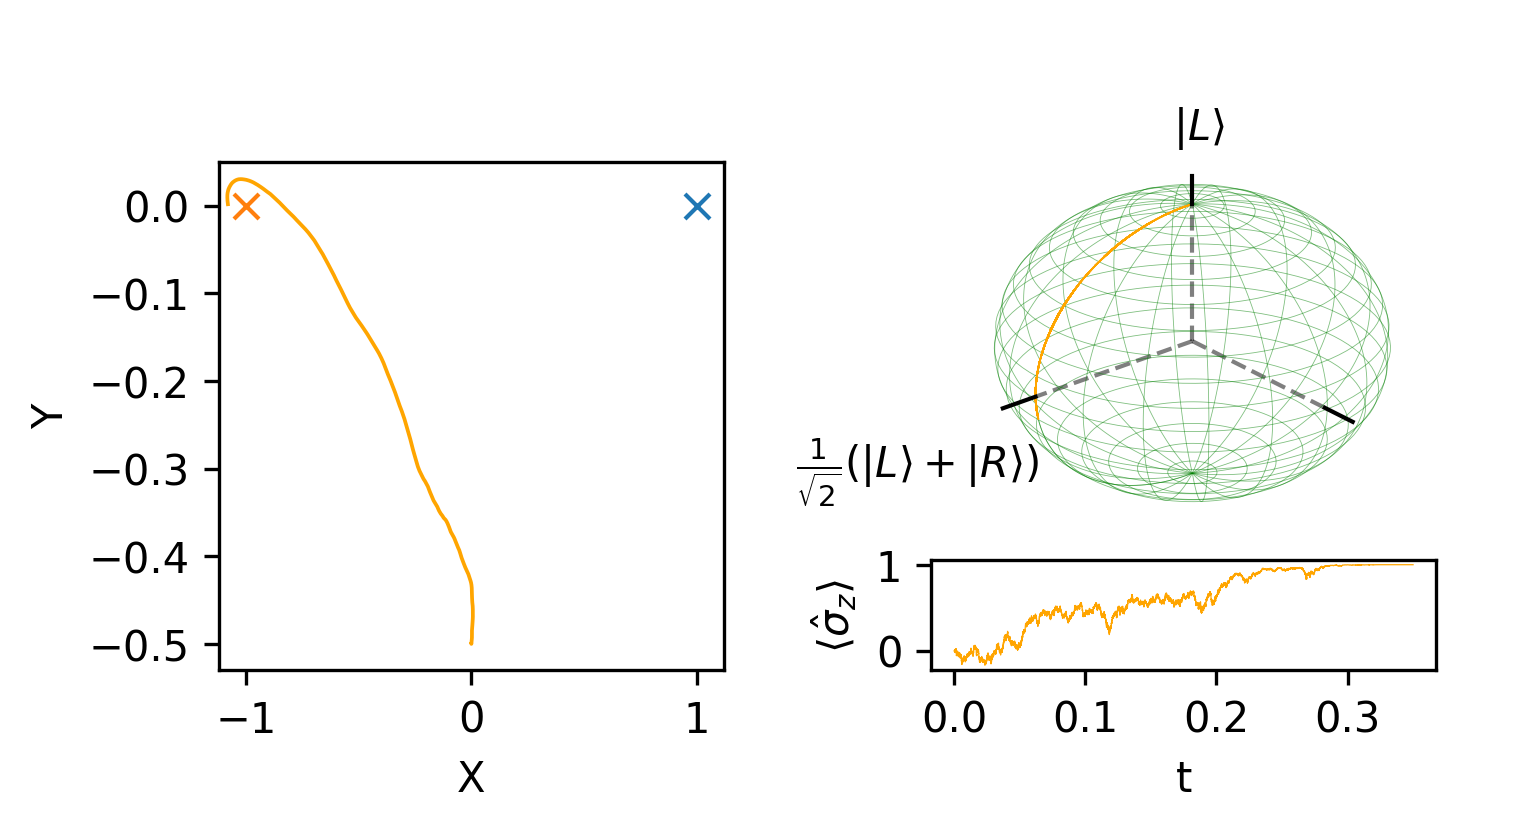

In [15]:
#define figure allowing multiple subplots
fig = plt.figure(facecolor="white")
spec = fig.add_gridspec(7, 8)
fig.tight_layout()

#classical trajectory subplot
ax = fig.add_subplot(spec[1:5,0:3])
plot_class(ax,Z_coord_s[0],Z_coord_s[1],lw=0.9)
ax.plot(1,0,"x")
ax.plot(-1,0,"x")
ax.set_xlim(-1.12, 1.12)
ax.set_ylim(-0.53, 0.05)
ax.set_xlabel("X")
ax.set_ylabel("Y")

#quantum trajectory subplots
ax2= fig.add_subplot(spec[0:5,3:8],projection='3d')
plot_quant(ax2,psi_s)

ax2.text(2.15,-0.4,-0.3,r'$\frac{1}{\sqrt{2}}(|L\rangle+|R\rangle)$')
ax2.text(0,-0.15,1.4,r'$|L\rangle$')
ax2.view_init(elev=25., azim=50)

ax3= fig.add_subplot(spec[4:5,4:7])
ax3.set_xlabel("t")
ax3.set_ylabel(r"$\langle\hat{\sigma}_z\rangle$")
zComponentPlot(ax3,psi_s,ts)

plt.show()

As we can see, the model has negligible rotation around the pole in the Bloch sphere; we may arrive at a dynamics that has a clearer representation of trajectories (and equivalent physics to an observer monitoring the classical test mass) by letting $\phi$ be non-zero:

In [16]:
#fix a seed and solve the dynamics 
state=np.random.RandomState(seed=249050)
(psi_s,Z_coord_s,Z_momen_s,ts)=massSupPosDynamics(t_f=0.35,N=35000,phi=5,sigma=0.05)

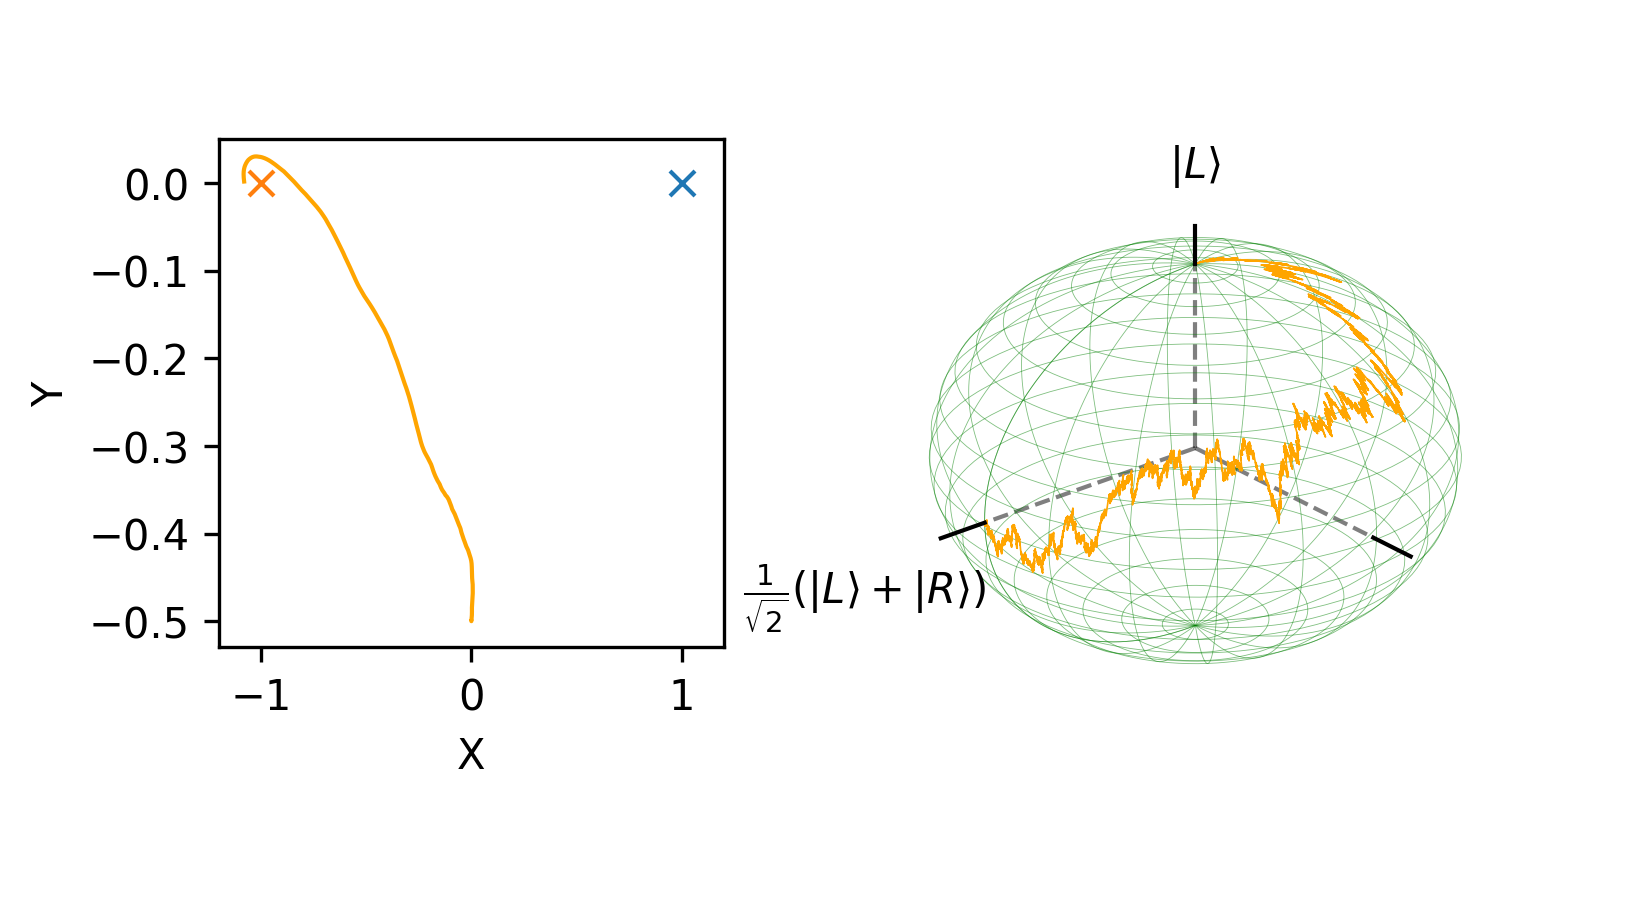

In [17]:
#define figure allowing multiple subplots
fig = plt.figure(facecolor="white")
spec = fig.add_gridspec(7, 8)
fig.tight_layout()

#classical trajectory subplot
ax = fig.add_subplot(spec[1:5,0:3])
plot_class(ax,Z_coord_s[0],Z_coord_s[1],lw=1)
ax.plot(1,0,"x")
ax.plot(-1,0,"x")
ax.set_xlim(-1.2, 1.2)
ax.set_ylim(-0.53, 0.05)
ax.set_xlabel("X")
ax.set_ylabel("Y")

#quantum trajectory subplots
ax2= fig.add_subplot(spec[0:7,3:8],projection='3d')
plot_quant(ax2,psi_s)
ax2.text(1.8,-0.4,-0.3,r'$\frac{1}{\sqrt{2}}(|L\rangle+|R\rangle)$')
ax2.text(0,-0.15,1.4,r'$|L\rangle$')
ax2.view_init(elev=25., azim=50)

plt.show()

## Toy model of vacuum fluctuations

Finally, we turn our attention to a model of multiple qubits each interacting locally with a classical degree of freedom $\phi_i$. Let $i=1,\ldots,n$ denote the sites on a 1D lattice, and $\hat{\sigma}_z^i$ be a local Pauli Z operator on the qubit associated to each site. We then consider the Hamiltonian

$$H(\phi_1,\ldots,\phi_n,\pi_1,\ldots,\pi_n)=\lambda \sum_{i=1}^n \phi_i \hat{\sigma}_z^i + \frac{\pi_i^2}{2m}$$

where $(\phi_i,\pi_i)$ obey the Poisson brackets $\{\phi_i,\pi_j\}=\delta_{ij}$ and $\{\phi_i,\phi_j\}=\{\pi_i,\pi_j\}=0$. Since we are interested in arbitrary $n$, we define the following vectorised functions/operators:

In [18]:
def dW_vec(n,delta_t):
    return np.array([dW(delta_t) for i in range(n)])

def Exp_vec(A,v):
    return np.array([Exp(B,v) for B in A])

def opVsExp_n(A,v,n):
    return A-np.identity(2**n)*np.vdot(v,np.dot(A,v))

def opVsExp2_vec(A,v,n):
    return np.array([opVsExp_n(B,v,n).dot(opVsExp_n(B,v,n)) for B in A]).sum(0)

def n_fold(n,A):
    B=A
    for i in range(n-1):
        B=np.kron(B,A)
    return B

def k_place(k,n,A):
    for i in range(n):
        if i==k:
            C=A
        else: 
            C=np.identity(2)
        if i==0:
            B=C
        else:
            B=np.kron(B,C)
    return B

def normCheck_n(psi,t,tolerance,n):
    I=np.identity(2**n)
    norm=Exp(I,psi)
    if norm>1+tolerance or norm<1-tolerance:    
        print("Norm is {0} at time {1}".format(norm,t))
        return 1  
              
    else:
        return 0



We then define a function to compute the dynamics for arbitrary $n$ (note here that phi_i, pi_i refer in the code to the vector of initial conditions, not a single element!):

In [19]:
def nQubitDynamics(n=5, phi_i=None, pi_i=None, psi_i=None, #default ICs are 0 in phase space and a cat state
                       t_i=0,t_f=0.3,N=60000, #default duration and stepsize
                       lambd=1,m=1,sigma=1, gamma=2, #default free parameters
                       standard_semi_class=False): 
    
    #time step
    dt     = float(t_f - t_i) / N
    
    #state space set-up
    ts = np.linspace(t_i, t_f, N)
    phi_s = np.zeros((N,n))
    pi_s  = np.zeros((N,n))
    psi_s = np.zeros((N,2**n),dtype = 'complex_')
    
    #operator set-up
    sz_vec=np.array([k_place(i,n,sz) for i in range(n)])

    #intial conditions
    if phi_i is None:
        phi_i=np.zeros(n)
    if pi_i is None:
        pi_i=np.zeros(n)
    if psi_i is None:
        ket0=np.array([1,0])
        ket1=np.array([0,1])
        psi_i=(n_fold(n,ket0)+n_fold(n,ket1))/np.sqrt(2)
        
    phi_s[0]=phi_i
    pi_s[0]=pi_i
    psi_s[0]=psi_i
              
    #turn off certain terms for standard semi-classical prediction
    a=1
    if standard_semi_class:
        a=0
    
    #euler-maruyama numerics
    for i in range(1, ts.size):
        t = t_i + (i - 1) * dt
        pi = pi_s[i - 1]
        phi = phi_s[i - 1]
        psi = psi_s[i - 1]

        dw=dW_vec(n,dt)
        pi_s[i] = pi + np.real(Exp_vec(sz_vec,psi))*dt + a*sigma * dw
        phi_s[i] = phi + (pi/m)*dt
    
        psi_s[i] = psi  + a*(lambd/(2*sigma))* opVsExp_n(np.einsum('i,i...', dw, sz_vec),psi,n).dot(psi) \
        - a*(lambd*lambd/(8*sigma*sigma))*opVsExp2_vec(sz_vec,psi,n).dot(psi)* dt \
        - 1j*lambd*(np.einsum('i,i...', phi+gamma, sz_vec)).dot(psi)*dt 
        
    return(psi_s,phi_s,pi_s,ts)        


To visualise this dynamics we define a new plotting function:

In [20]:
import matplotlib.cm as cm   
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Line3DCollection

def plotnQubit(psi_s,phi_s):
    
    n=phi_s.shape[1]
    N=phi_s.shape[0]-1

    plt.rcParams["figure.dpi"] = 300
    fig = plt.figure(facecolor="white")
    spec = fig.add_gridspec(8, 8)

    fig.tight_layout()
    
    #colour choice
    cmap = cm.get_cmap('plasma')

    #### classical subplot ####
    ax = fig.add_subplot(spec[1:7,0:3])
    listn=np.arange(1,n+1,1)
    
    for i in np.arange(1,7):
        ax.scatter(listn,phi_s[int((i-1)*(N)/5)],lw=0.3,color=cmap((i/6)),zorder=i+1,alpha=1)

    ax.set_xticks(listn)
    ax.set_xlabel("i")
    ax.set_ylabel(r"$\phi_i$")
    ax.grid(True)
    
    #### quantum subplot ####
    
    sx_n=n_fold(n,sx)
    sy_n=n_fold(n,sy)
    sz_n=n_fold(n,sz)
    
    #coordinates of trajectory on sphere
    sx_n_s=[np.real(Exp(sx_n,psi)) for psi in psi_s]
    sy_n_s=[np.real(Exp(sy_n,psi)) for psi in psi_s]
    sz_n_s=[np.real(Exp(sz_n,psi)) for psi in psi_s]
    
    
    #create sphere
    ax2= fig.add_subplot(spec[0:8,3:8],projection='3d')

    r = 1
    pi = np.pi
    cos = np.cos
    sin = np.sin
    phi, theta = np.mgrid[0.0:pi:100j, 0.0:2.0*pi:100j]
    x = r*sin(phi)*cos(theta)
    y = r*sin(phi)*sin(theta)
    z = r*cos(phi)

    ax2.plot_wireframe(x, y, z, rstride=5, cstride=5, color='g', alpha=0.5, linewidth=0.2,zorder=1)
    
    ax2.plot([0,1],[0,0],[0,0],'k-', linewidth=1,linestyle="dashed",alpha=0.5)
    ax2.plot([1,1.2],[0,0],[0,0],'k-', linewidth=1)
    ax2.plot([0,0],[0,1],[0,0],'k-', linewidth=1,linestyle="dashed",alpha=0.5)
    ax2.plot([0,0],[1,1.2],[0,0],'k-', linewidth=1)
    ax2.plot([0,0],[0,0],[0,1],'k-', linewidth=1,linestyle="dashed",alpha=0.5)
    ax2.plot([0,0],[0,0],[1,1.2],'k-', linewidth=1,zorder=10)

    ax2.set_facecolor("none")
    ax2.set_axis_off()
    ax2.set_xlim(-1, 1)
    ax2.set_ylim(-1, 1)
    ax2.set_zlim(-1, 1)

    #create a colored line on Bloch sphere from coordinates
    points = np.array([sx_n_s, sy_n_s, sz_n_s]).T.reshape(-1, 1, 3)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    lc = Line3DCollection(segments, cmap=cmap,norm=plt.Normalize(0, 1))
    lc.set_array(ts/ts[N]) 
    lc.set_linewidth(0.3)

    #plot coloured line and colourbar
    ax2.add_collection3d(lc, zs=ts, zdir='z')
    line = ax2.add_collection(lc)
    fig.colorbar(line, ax=ax2, orientation="horizontal",pad=-0.1, label=r"$t/t_f$", shrink=0.5)
    
    #labelling
    ax2.text(1.83,0,0.1,r'$|cat\rangle$')
    ax2.text(0,-0.09,1.4,r'$|0\rangle^{\otimes 5}$')

    #labelling
    

    ax2.view_init(elev=25., azim=33)
    
    return fig

    

We now run the code for its default values. Note that the values will only lie on the sphere for odd $n$:

In [21]:
state=np.random.RandomState(seed=104)
(psi_s,phi_s,pi_s,ts)=nQubitDynamics()

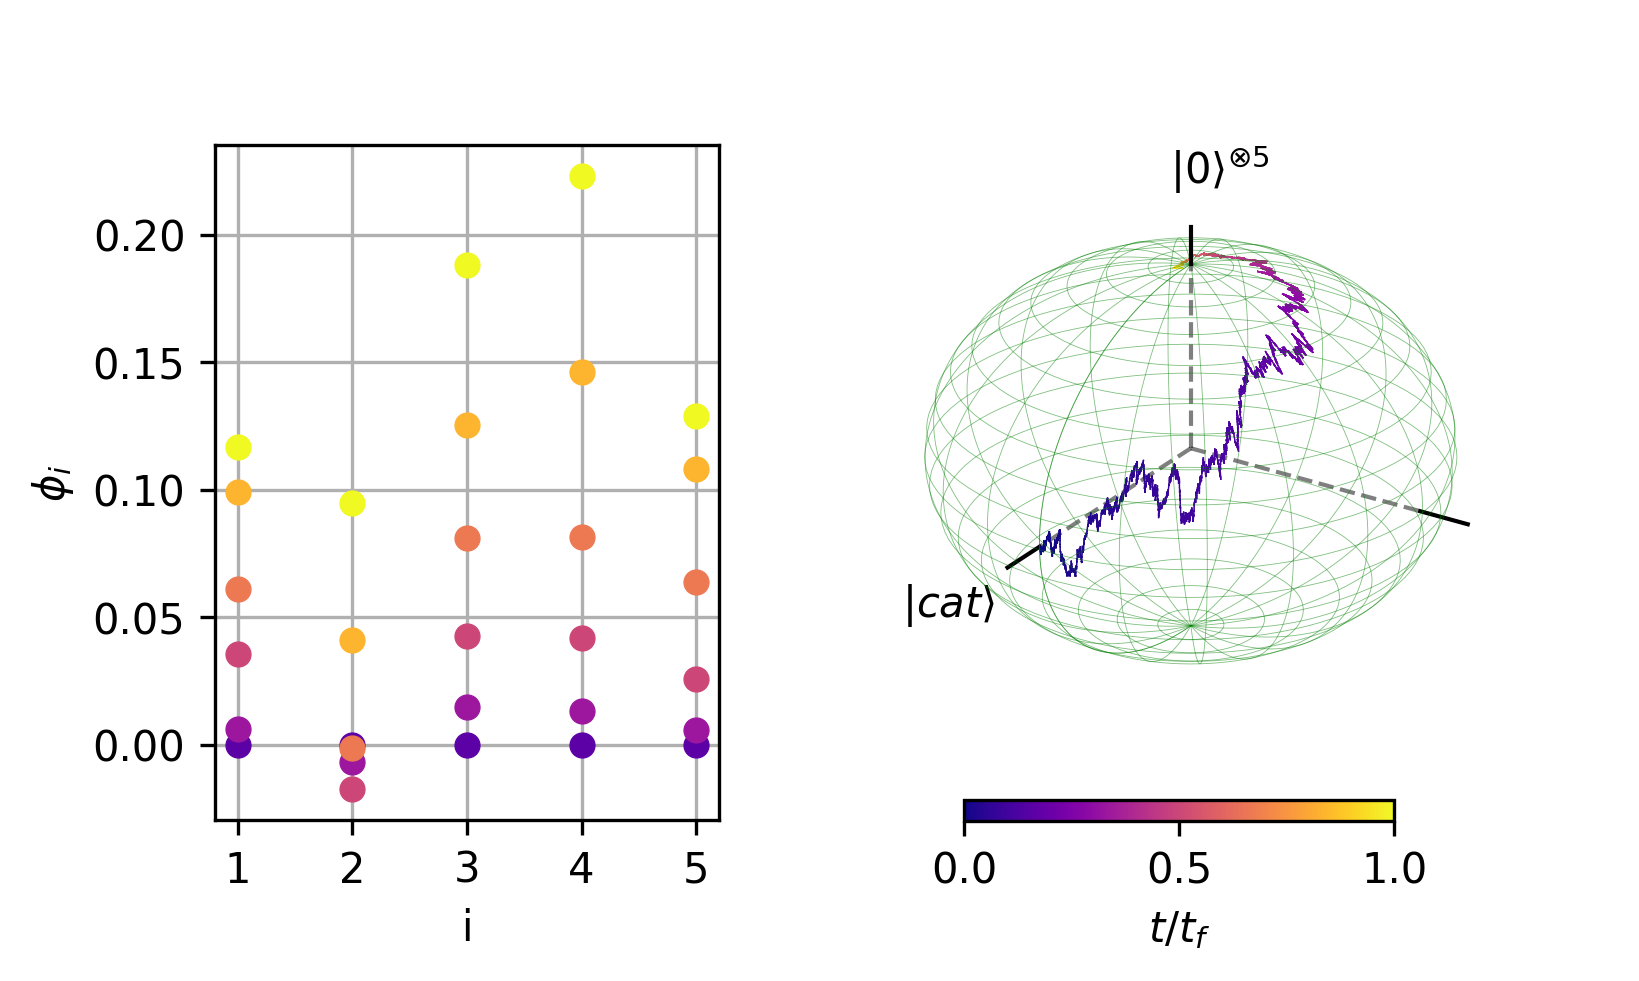

In [22]:
fig=plotnQubit(psi_s,phi_s)

plt.show()